In [30]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Thesis_work/ML_experiments'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/16LLv0tl9NuELAOpNIA0EW8v8njV1fcVa/Thesis_work/ML_experiments


#Loading libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
#!pip install xgboost
from xgboost import XGBClassifier
# !pip install catboost
# from catboost import CatBoostRegressor
import sklearn
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

#Method for confusion matrix plot

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(Y, predicted):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(Y, Y_predicted_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(Y, Y_predicted_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(Y, Y_predicted_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(Y, Y_predicted_classes)
  print('F1 score: %f' % f1)
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#Load the dataset


In [33]:
data = pd.read_csv('final_dataset_reviews_clean.csv')
# data.drop(columns=['Unnamed: 0'], inplace = True)
data.head(2)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,TE111EL1,itzmr7,6702,2019-11-09,1,0,mil gya hai acha hai aur toota howa b nai hai,Positive,['toota'],45,...,0.051918,0,1,-2.000000,-2.000000,acha tota howa nahi,1.0,19,4,539
1,MI543EL0,Afridi,396,2016-11-21,5,0,aram sy pocket may aa jta hai aur quality b ac...,Positive,"['aram', 'pocket', 'quality']",52,...,0.035987,1,1,0.466667,0.466667,aram pocket jta quality achi,1.0,28,5,336


#TRain and test data

In [34]:
spam_true = data[data['Label']==1]
spam_true=sklearn.utils.shuffle(spam_true, random_state=10)
print(spam_true.shape)
test_true = spam_true[:100]
train_true=spam_true[100:]
spam_false = data[data['Label']==0]
print(spam_false.shape)
spam_false=sklearn.utils.shuffle(spam_false, random_state=10)
test_false = spam_false[:100]
train_false=spam_false[100:]
train_data = pd.concat([train_true,train_false], ignore_index=True, sort=False)
train_data.to_csv('Spam_clean_train'+'.csv', index=False)
test_data = pd.concat([test_true,test_false],ignore_index=True, sort=False)
test_data.to_csv('Spam_clean_test'+'.csv', index=False)

(530, 23)
(3393, 23)


In [35]:
df_train=pd.read_csv('Spam_clean_train.csv');
df_test=pd.read_csv('Spam_clean_test.csv');

In [36]:
df_train.head(2)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,VI363HL1,Nasir Arafat Anwar,3953,2017-07-03,5,1,meri wife isse cooking mein istemaal kar rahi ...,Positive,['wife'],73,...,0.043131,1,0,2.250000,2.250000,meri wife coking istemal bohat kam araha,1.0,40,7,589
1,UB622ME1,Hamza,2020,2016-11-14,5,1,bilkul seal pack haalat mein mila aur mein iss...,Negative,"['seal', 'pack', 'haalat', 'masnoaat', 'khush']",71,...,0.053663,1,0,0.098039,0.333333,bilkul seal pack halat mila masnoat khush,0.0,41,7,574


##Features and label

In [37]:
X_train=df_train.drop(columns=[ 'Sentiment_class', 'Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
X_test=df_test.drop(columns=['Sentiment_class', 'Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
y_train=df_train['Label']
y_test=df_test['Label']


#Resampling Technique ROS(Over sampling)

In [38]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
# X_train_ru, y_train_ru = ros.fit_resample(X_train, y_train)
X_train_ru = X_train
y_train_ru=y_train

In [39]:
X_train_ru.shape

(3723, 14)

In [40]:
X_test.shape

(200, 14)

#Basic Classification Models

##XGBoost

Accuracy: 0.665000
Precision: 0.883721
Recall: 0.380000
F1 score: 0.531469
(2, 2)
(2, 2)


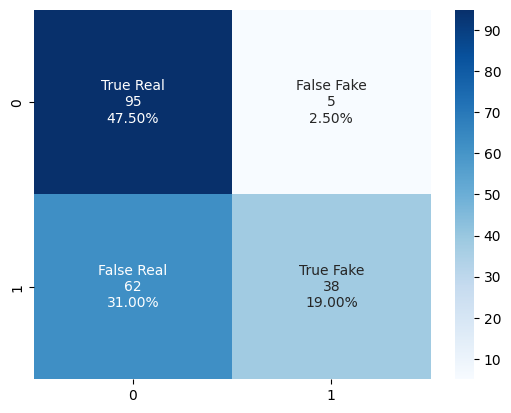

In [41]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# fit model training data
model = XGBClassifier()

model.fit(X_train_ru, y_train_ru)

#---Without feature selection and parameter tuning------
pred_xg = model.predict(X_test)
# evaluate predictions
plot_confusion_matrix(y_test,pred_xg)


##**Gradient Boosting**

              precision    recall  f1-score   support

           0       0.54      0.98      0.70       100
           1       0.89      0.16      0.27       100

    accuracy                           0.57       200
   macro avg       0.71      0.57      0.48       200
weighted avg       0.71      0.57      0.48       200

Accuracy: 0.570000
Precision: 0.888889
Recall: 0.160000
F1 score: 0.271186
(2, 2)
(2, 2)


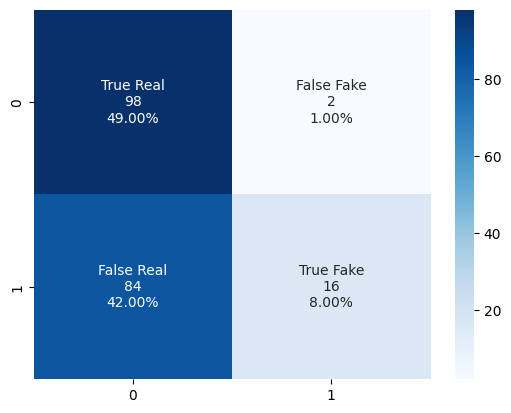

In [42]:
model_gb = GradientBoostingClassifier()

#-------- Without Feature selection---------
model_gb.fit(X_train_ru,y_train_ru)
pred_gb = model_gb.predict(X_test)
print(classification_report(y_test, pred_gb))

#-----evaluate results-----
plot_confusion_matrix(y_test,pred_gb)


##Light GBM

[LightGBM] [Info] Number of positive: 430, number of negative: 3293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 3723, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115498 -> initscore=-2.035769
[LightGBM] [Info] Start training from score -2.035769
Accuracy: 0.685000
Precision: 0.951220
Recall: 0.390000
F1 score: 0.553191
(2, 2)
(2, 2)


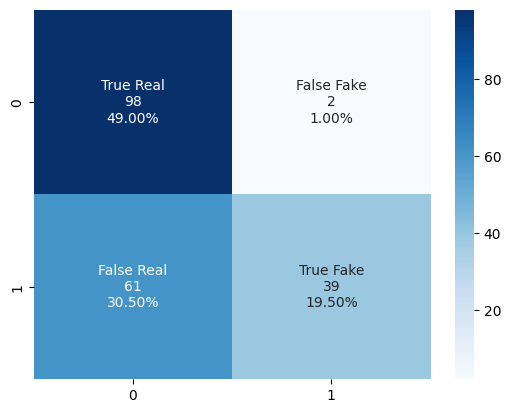

In [43]:
model_lg = lgb.LGBMClassifier()
model_lg.fit(X_train_ru, y_train_ru)
pred_lg = model_lg.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_lg)

##Decision Tree

Accuracy: 0.635000
Precision: 0.787234
Recall: 0.370000
F1 score: 0.503401
(2, 2)
(2, 2)


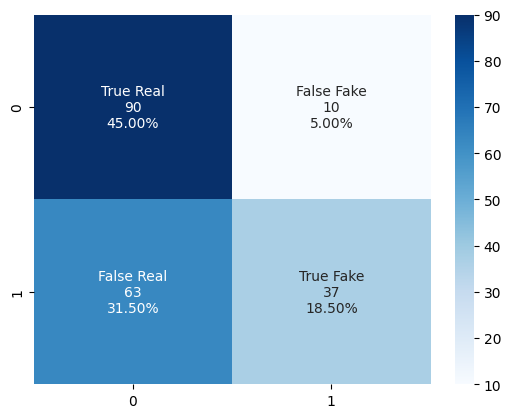

In [44]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_ru, y_train_ru)
pred_dt = model_dt.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_dt)

##Naive bayes

Accuracy: 0.500000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


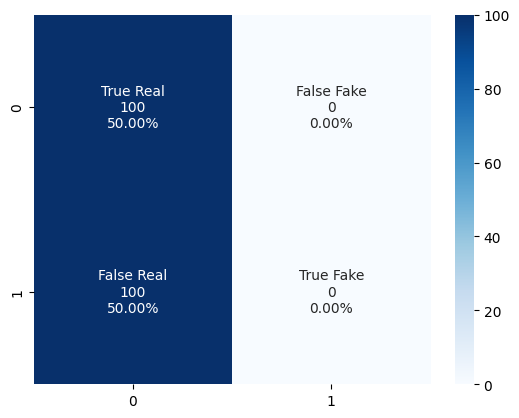

In [45]:
#Bernoulli Navie Bayes Classifier
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train_ru, y_train_ru)
pred_nb = BNB_Classifier.predict(X_test)
# print("\nClassification report for BernoulliNB Classifier %s:\n%s\n" % (BNB_Classifier, metrics.classification_report(y_test, pred_nb)))
plot_confusion_matrix(y_test,pred_nb)


Accuracy: 0.580000
Precision: 0.735294
Recall: 0.250000
F1 score: 0.373134
(2, 2)
(2, 2)


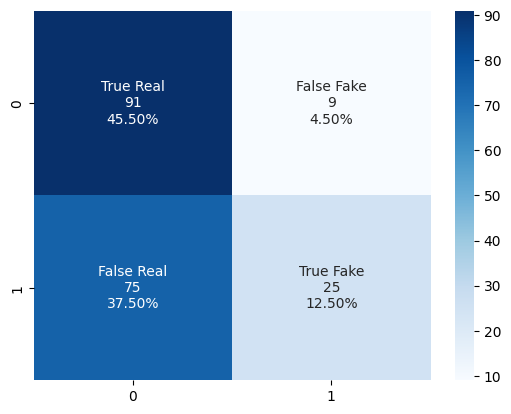

In [46]:
#Bernoulli Navie Bayes Classifier
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train_ru, y_train_ru)
GNB_Predictions =  GNB_Classifier.predict(X_test)
plot_confusion_matrix(y_test,GNB_Predictions)

##Logistic REgression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.500000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


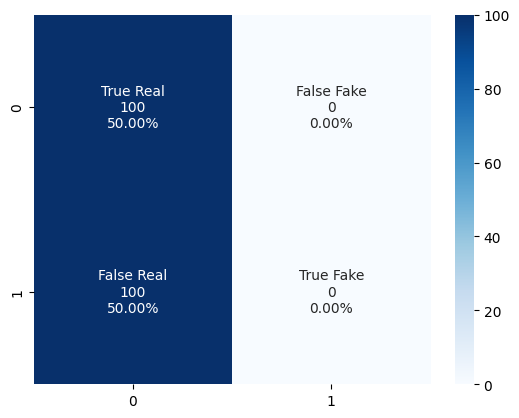

In [47]:
LR_Classifier = LogisticRegression()
LR_Classifier.fit(X_train_ru, y_train_ru)
pred_lr = LR_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_lr)

##Support VEctor

Accuracy: 0.500000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


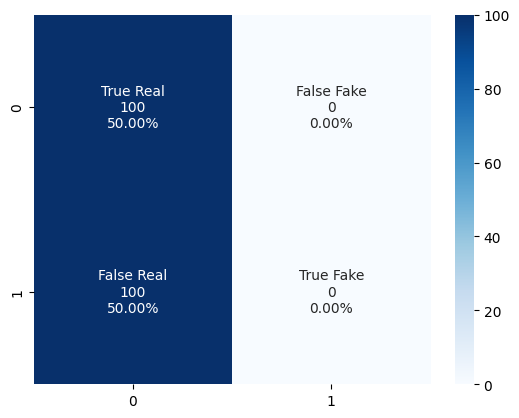

In [48]:
#SVC Classifier
SVC_Classifier = SVC()
SVC_Classifier.fit(X_train_ru, y_train_ru)
pred_svc = SVC_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_svc)

##**Random Forest Classifier**

accuracy 0.58
Accuracy: 0.580000
Precision: 0.944444
Recall: 0.170000
F1 score: 0.288136
(2, 2)
(2, 2)


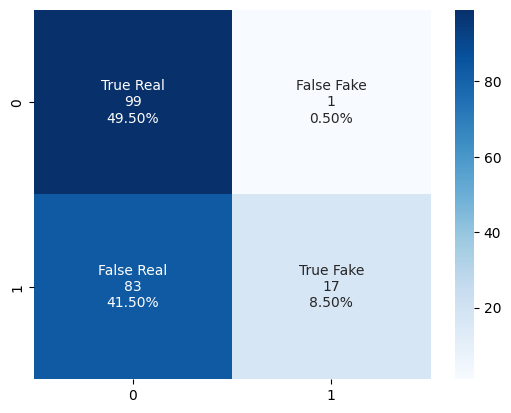

In [49]:

model_rf = RandomForestClassifier(n_estimators=110)
model_rf.fit(X_train_ru,y_train_ru)
pred_rf = model_rf.predict(X_test)
print('accuracy %s' % accuracy_score(pred_rf, y_test))
#print(classification_report(y_test, pred_rf))
plot_confusion_matrix(y_test,pred_rf)

##**Stochastic Gradient Descent**

Accuracy: 0.500000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


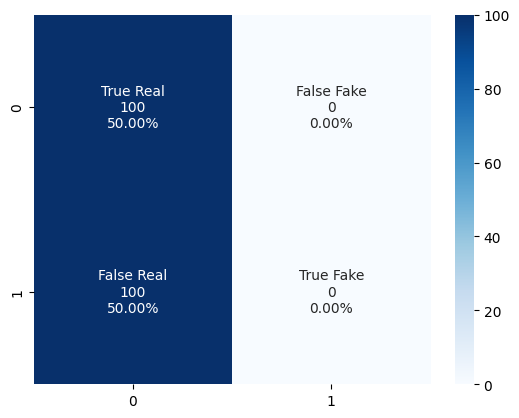

In [50]:

model_sg = SGDClassifier()
model_sg.fit(X_train_ru,y_train_ru)
pred_sg = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_sg)

##ANN

In [51]:
X_train_ru.shape[1]

14

In [52]:
from keras import models
from keras import layers
dnn = models.Sequential()
dnn.add(layers.Dense(16, activation = 'relu', input_shape=(X_train_ru.shape[1],)))
dnn.add(layers.Dropout(0.3))
dnn.add(layers.Dense(8, activation = 'relu', input_shape=(X_train_ru.shape[1],)))

dnn.add(layers.Dense(1, activation = 'sigmoid'))

dnn.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = dnn.fit(X_train_ru,
                  y_train_ru,
                    batch_size=40)

dnn.evaluate(X_test,y_test)

7/7 [==============================] - 0s 3ms/step - loss: 15.9596 - accuracy: 0.5000


[15.959571838378906, 0.5]

Accuracy: 0.500000
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


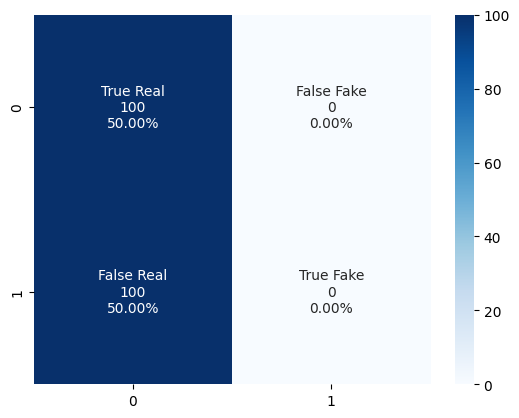

In [53]:
pred_ann = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_ann)

#**Best model Accuracy and F-score**

We tested six different models and now, we check which one is the best:

In [54]:
xg_acc = accuracy_score(pred_xg, y_test)
gb_acc = accuracy_score(pred_gb, y_test)
nb_acc = accuracy_score(pred_nb, y_test)
rf_acc = accuracy_score(pred_rf, y_test)
sg_acc = accuracy_score(pred_sg, y_test)
svm_acc = accuracy_score(pred_svc, y_test)
lr_acc = accuracy_score(pred_lr, y_test)
dt_acc = accuracy_score(pred_dt, y_test)
ann_acc = accuracy_score(pred_ann, y_test)
lgb_acc = accuracy_score(pred_lg,y_test)

xg_f1 = f1_score(pred_xg, y_test)
gb_f1 = f1_score(pred_gb, y_test)
nb_f1 = f1_score(pred_nb, y_test)
rf_f1 = f1_score(pred_rf, y_test)
sg_f1 = f1_score(pred_sg, y_test)
svm_f1 = f1_score(pred_svc, y_test)
lr_f1 = f1_score(pred_lr, y_test)
dt_f1 = f1_score(pred_dt, y_test)
ann_f1 = f1_score(pred_ann, y_test)
lgb_f1 = f1_score(pred_lg,y_test)

In [55]:
models = pd.DataFrame({
                      'Model': ['Extreme Gradient','Light GBM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD', 'Logistic Regression', 'Decision Tree', 'ANN'],
                      'Accuracy': [xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc],
                      'F-Score': [xg_f1, lgb_f1, nb_f1, rf_f1, gb_f1, svm_f1, sg_f1, lr_f1, dt_f1, ann_f1]
                       })
models.sort_values(by='F-Score', ascending=False, inplace=True)


In [56]:
models

,Model,Accuracy,F-Score
1,Light GBM,0.685,0.553191
0,Extreme Gradient,0.665,0.531469
8,Decision Tree,0.635,0.503401
3,Random Forest,0.580,0.288136
4,Gradient Boosting,0.570,0.271186
2,Naive Bayes,0.500,0.000000
5,SVM,0.500,0.000000
6,SGD,0.500,0.000000
7,Logistic Regression,0.500,0.000000
9,ANN,0.500,0.000000


##save results

In [57]:
models.to_csv("paper/expsettingIV_ROS_80.csv", index=False)

#Grouped confusion matrix

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


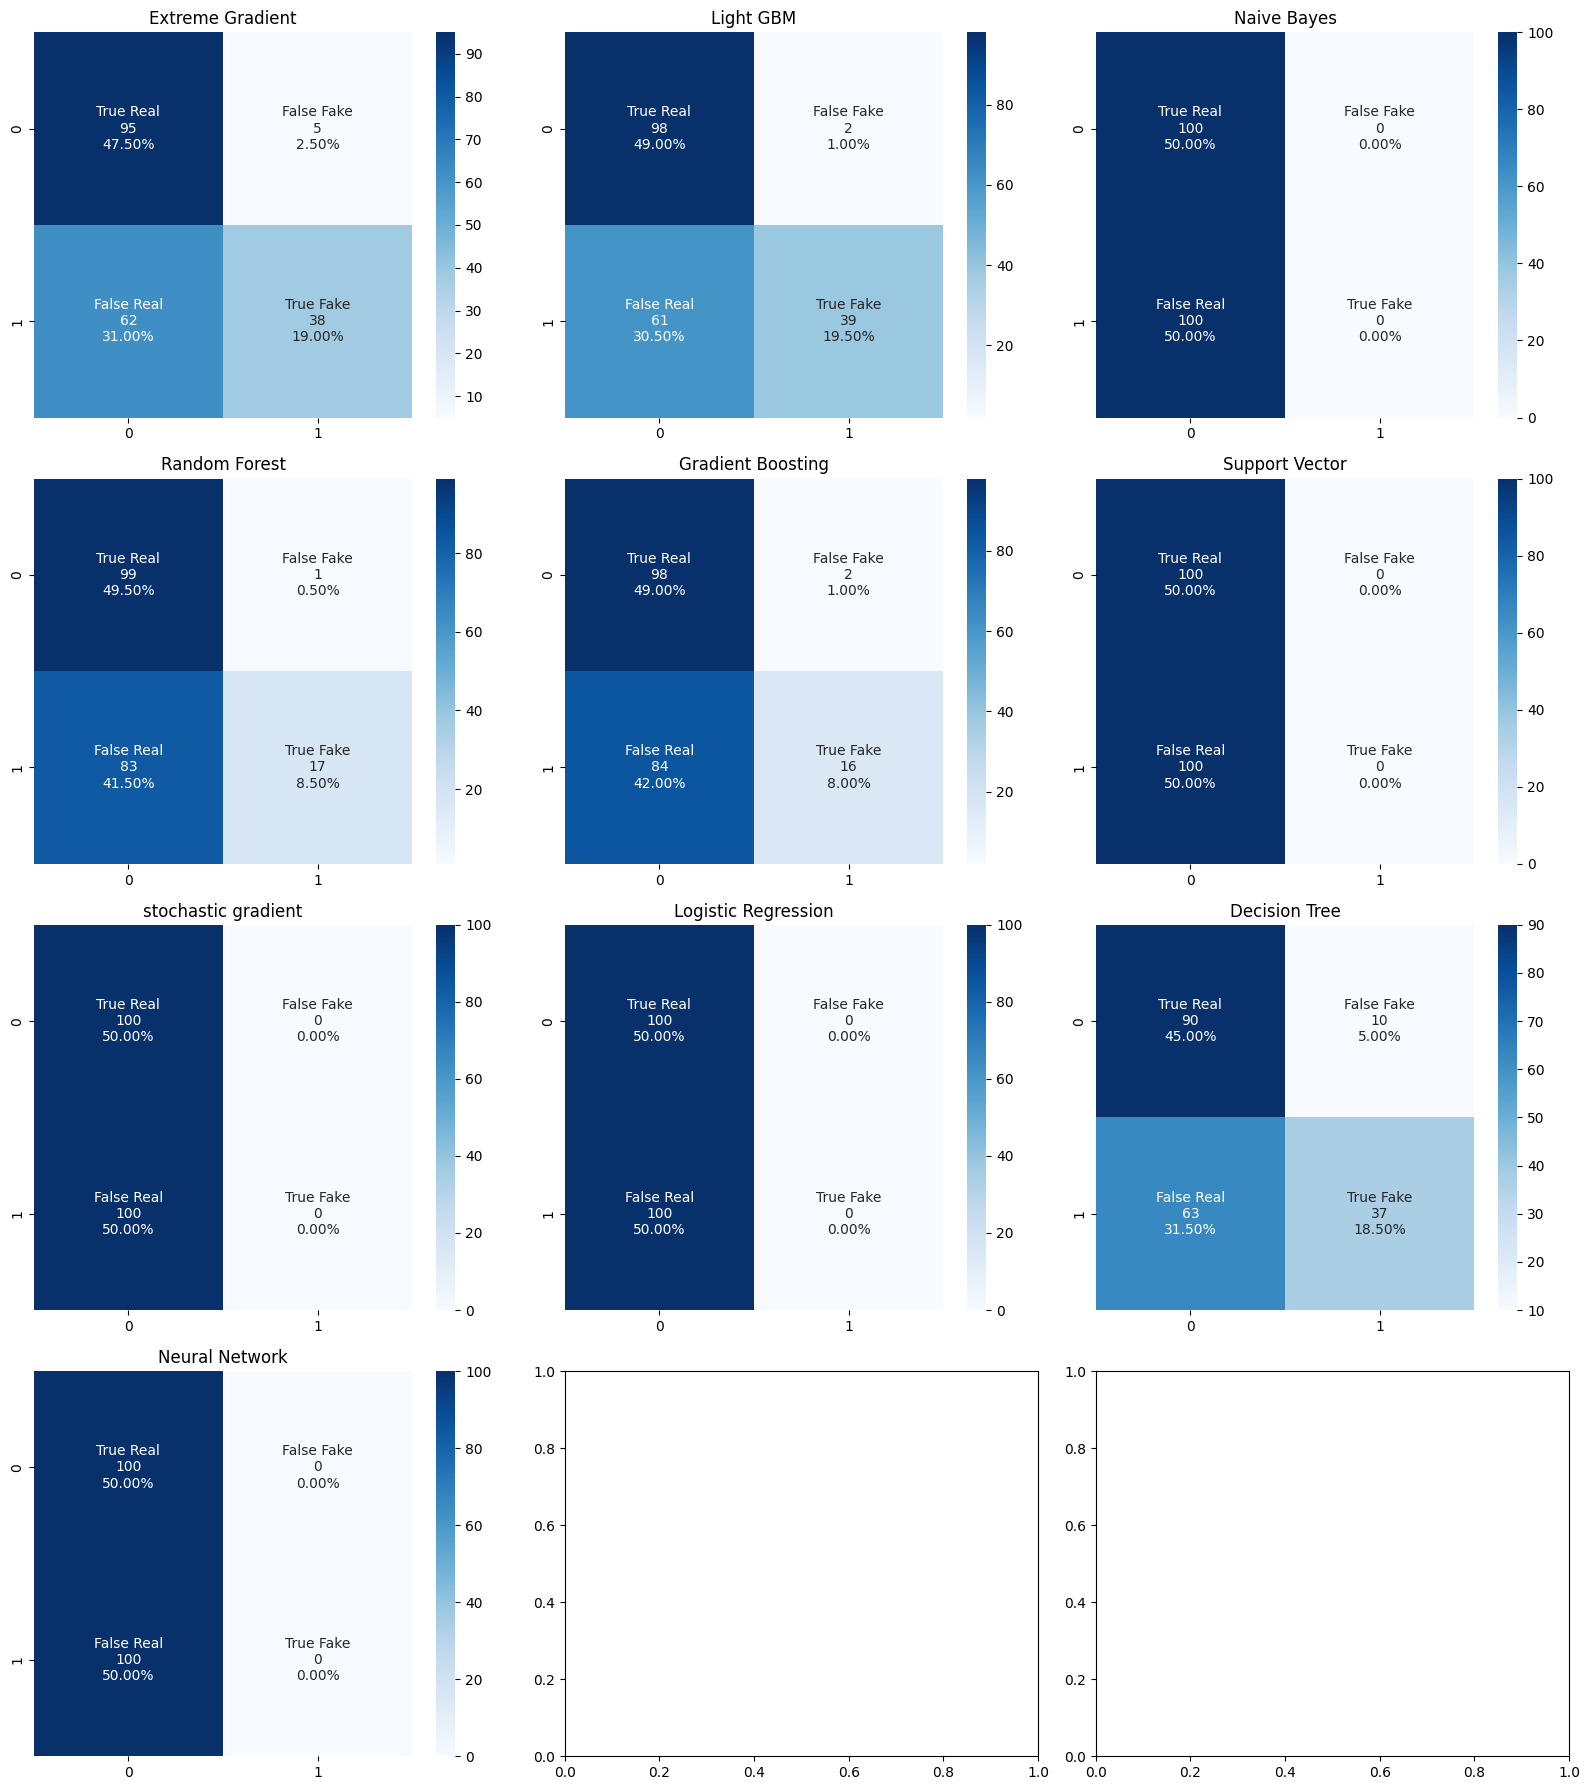

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
fig, axes = plt.subplots(4, 3, figsize=(16, 18))

def plot_grouped_cm(Y, predicted, r,c, model):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax =axes[r,c])
  axes[r,c].set_title(model)
xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc
plot_grouped_cm(y_test, pred_xg, 0,0, 'Extreme Gradient')
plot_grouped_cm(y_test, pred_lg, 0,1, 'Light GBM')
plot_grouped_cm(y_test, pred_nb, 0,2, 'Naive Bayes')
plot_grouped_cm(y_test, pred_rf, 1,0, 'Random Forest')
plot_grouped_cm(y_test, pred_gb, 1,1, 'Gradient Boosting')

plot_grouped_cm(y_test, pred_svc, 1,2, 'Support Vector')
plot_grouped_cm(y_test, pred_sg, 2,0, 'stochastic gradient')
plot_grouped_cm(y_test, pred_lr, 2,1, 'Logistic Regression')
plot_grouped_cm(y_test, pred_dt, 2,2, 'Decision Tree')
plot_grouped_cm(y_test, pred_ann, 3,0, 'Neural Network')



fig.tight_layout()
fig.savefig("paper/expsettingIV_ROS_80.png")